In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [6]:
def interpolate_wave_heights(original_data, grid_size=900, height_column='SWH'):
    """Interpolate wave height data to a finer grid"""
    points = original_data[['LON', 'LAT']].values
    values = original_data[height_column].values
    
    lon_min, lon_max = 30, 120
    lat_min, lat_max = -60, 30
    
    lon_grid = np.linspace(lon_min, lon_max, grid_size)
    lat_grid = np.linspace(lat_min, lat_max, grid_size)
    grid_lon, grid_lat = np.meshgrid(lon_grid, lat_grid)
    
    grid_wave_heights = griddata(points, values, (grid_lon, grid_lat), method='linear')
    grid_wave_heights = np.nan_to_num(grid_wave_heights, nan=0)

    flipped_grid = np.flipud(grid_wave_heights)
    
    return grid_lon, grid_lat, flipped_grid

In [63]:
def interpolate_wind_directions(original_data, grid_size=900, direction_column='WINDDIR'):
    """
    Interpolates wind direction data to a finer grid while accounting for circular nature.

    Args:
        original_data (pd.DataFrame): DataFrame containing 'LON', 'LAT', and wind direction column.
        grid_size (int): The resolution of the interpolation grid.
        direction_column (str): Name of the column containing wind direction in degrees.

    Returns:
        tuple: grid_lon, grid_lat, interpolated_wind_directions
    """
    # Extract points and wind directions
    points = original_data[['LON', 'LAT']].values
    wind_directions = original_data[direction_column].values

    # Convert wind directions to radians
    wind_directions_rad = np.deg2rad(wind_directions)

    # Decompose into vector components
    u = np.cos(wind_directions_rad)
    v = np.sin(wind_directions_rad)

    # Define the interpolation grid
    lon_min, lon_max = 30, 120
    lat_min, lat_max = -60, 30
    lon_grid = np.linspace(lon_min, lon_max, grid_size)
    lat_grid = np.linspace(lat_min, lat_max, grid_size)
    grid_lon, grid_lat = np.meshgrid(lon_grid, lat_grid)

    # Interpolate vector components
    grid_u = griddata(points, u, (grid_lon, grid_lat), method='linear')
    grid_v = griddata(points, v, (grid_lon, grid_lat), method='linear')

    # Replace NaNs with zeros to handle missing data
    grid_u = np.nan_to_num(grid_u, nan=0)
    grid_v = np.nan_to_num(grid_v, nan=0)

    # Reconstruct wind directions from interpolated components
    grid_wind_directions_rad = np.arctan2(grid_v, grid_u)
    grid_wind_directions = np.rad2deg(grid_wind_directions_rad)

    # Normalize to [0, 360) range
    grid_wind_directions = (grid_wind_directions + 360) % 360

    grid = np.flipud(grid_wind_directions)
    return grid_lon, grid_lat, grid

In [99]:
def dataframe_to_matrix(dataframe, lat_range, lon_range, val = 'USURF', resolution=0.083):
    """
    Converts a DataFrame with latitudes, longitudes, and values to a 2D matrix.

    Args:
        dataframe (pd.DataFrame): DataFrame with 'LAT', 'LON', and value columns.
        lat_range (tuple): Latitude range (min, max).
        lon_range (tuple): Longitude range (min, max).
        resolution (float): Resolution of the grid.

    Returns:
        np.ndarray: 2D matrix of values with missing data defaulted to 0.
    """
    lat_min, lat_max = lat_range
    lon_min, lon_max = lon_range

    # Calculate grid dimensions
    num_rows = int((lat_max - lat_min) / resolution)
    num_cols = int((lon_max - lon_min) / resolution)

    # Initialize matrix with zeros
    matrix = np.zeros((num_rows, num_cols))

    # Map DataFrame values to the matrix
    for _, row in dataframe.iterrows():
        lat, lon, value = row['LAT'], row['LON'], row[val]

        # Skip rows with invalid or out-of-range lat/lon
        if not (lat_min <= lat <= lat_max and lon_min <= lon <= lon_max):
            continue

        # Calculate indices
        lat_idx = int((lat - lat_min) / resolution)
        lon_idx = int((lon - lon_min) / resolution)

        # Assign the value to the matrix
        matrix[lat_idx, lon_idx] = value

    return matrix



In [86]:
def dataframe_to_matrix1(dataframe, lat_range, lon_range, resolution=0.083334):
    """
    Converts a DataFrame with latitudes, longitudes, and values to a 2D matrix.

    Args:
        dataframe (pd.DataFrame): DataFrame with 'latitude', 'longitude', and value columns.
        lat_range (tuple): Latitude range (min, max).
        lon_range (tuple): Longitude range (min, max).
        resolution (float): Resolution of the grid.

    Returns:
        np.ndarray: 2D matrix of values with missing data defaulted to 0.
    """
    lat_min, lat_max = lat_range
    lon_min, lon_max = lon_range

    # Calculate grid dimensions (including edge cases)
    num_rows = int((lat_max - lat_min) / resolution) + 1
    num_cols = int((lon_max - lon_min) / resolution) + 1

    # Initialize matrix with zeros
    matrix = np.zeros((num_rows, num_cols))

    # Map DataFrame values to the matrix
    for _, row in dataframe.iterrows():
        lat, lon, value = row['Latitude'], row['Longitude'], row['Salt']

        # Skip rows with invalid or out-of-range lat/lon
        if not (lat_min <= lat <= lat_max and lon_min <= lon <= lon_max):
            continue

        # Calculate indices (clamp to avoid out-of-bounds errors)
        lat_idx = min(int((lat - lat_min) / resolution), num_rows - 1)
        lon_idx = min(int((lon - lon_min) / resolution), num_cols - 1)

        # Assign the value to the matrix
        matrix[lat_idx, lon_idx] = value

    return matrix

In [7]:
def average_pooling(matrix, output_shape):
    """
    Applies average pooling to a 2D matrix.

    Args:
        matrix (np.ndarray): Input 2D matrix.
        output_shape (tuple): Desired output shape (rows, cols).

    Returns:
        np.ndarray: Averaged down-sampled matrix.
    """
    input_rows, input_cols = matrix.shape
    output_rows, output_cols = output_shape

    row_scale = input_rows // output_rows
    col_scale = input_cols // output_cols

    pooled_matrix = np.zeros((output_rows, output_cols))
    for i in range(output_rows):
        for j in range(output_cols):
            pooled_matrix[i, j] = np.mean(
                matrix[i * row_scale:(i + 1) * row_scale, j * col_scale:(j + 1) * col_scale]
            )

    flipped_grid = np.flipud(pooled_matrix)        

    return flipped_grid

In [8]:
def expand_matrix_to_square(matrix, target_size=900):
    """
    Expands a rectangular matrix to a square matrix of the given size by padding with zeros.

    Args:
        matrix (np.ndarray): Input matrix to be expanded.
        target_size (int): Desired size of the square matrix.

    Returns:
        np.ndarray: Square matrix with original values and zero padding.
    """
    original_rows, original_cols = matrix.shape
    if original_rows > target_size or original_cols > target_size:
        raise ValueError("Target size must be greater than or equal to the original dimensions.")

    # Initialize a zero-filled matrix of the target size
    expanded_matrix = np.zeros((target_size, target_size))

    # Copy the original matrix into the top-left corner
    expanded_matrix[:original_rows, :original_cols] = matrix

    return expanded_matrix

In [10]:
def extract_data_roms(input_df, target_time):
    """
    Extracts relevant data rows from a DataFrame based on a target timestamp.

    Args:
        input_df (pd.DataFrame): The input DataFrame.
        target_time (str): The target timestamp to filter the data.

    Returns:
        pd.DataFrame: The filtered DataFrame containing the relevant data.
    """
    # Print available columns and first few rows for debugging
    print("Available Columns:", list(input_df.columns))
    print("\nFirst few rows:\n", input_df.head())

    # Check the actual format of the timestamp column
    print("\nTimestamp Column Format:")
    print(input_df['TAXIS'].dtype)
    print("\nUnique Timestamps:\n", input_df['TAXIS'].unique())

    # Attempt different filtering methods
    # Method 1: Direct comparison
    filtered_df = input_df[input_df['TAXIS'] == target_time]

    # Method 2: String parsing
    if len(filtered_df) == 0:
        filtered_df = input_df[input_df['TAXIS'].astype(str) == str(target_time)]

    # Print filtering results
    print(f"\nFiltered rows count: {len(filtered_df)}")

    # Select the relevant columns
    columns_to_extract = ['LON', 'LAT', 'USURF', 'VSURF', 'SST']

    # Check if all columns exist
    missing_columns = [col for col in columns_to_extract if col not in input_df.columns]
    if missing_columns:
        print(f"Warning: Columns {missing_columns} not found in the dataset")
        columns_to_extract = [col for col in columns_to_extract if col in input_df.columns]

    # Extract the required columns
    extracted_data = filtered_df[columns_to_extract]

    # Return the filtered DataFrame
    return extracted_data

In [11]:
def extract_data_wave(input_df, target_time):
    """
    Extracts relevant data rows from a DataFrame based on a target timestamp.

    Args:
        input_df (pd.DataFrame): The input DataFrame.
        target_time (str): The target timestamp to filter the data.

    Returns:
        pd.DataFrame: The filtered DataFrame containing the relevant data.
    """
    # Print available columns and first few rows for debugging
    print("Available Columns:", list(input_df.columns))
    print("\nFirst few rows:\n", input_df.head())

    # Check the actual format of the timestamp column
    print("\nTimestamp Column Format:")
    print(input_df['TIME'].dtype)
    print("\nUnique Timestamps:\n", input_df['TIME'].unique())

    # Attempt different filtering methods
    # Method 1: Direct comparison
    filtered_df = input_df[input_df['TIME'] == target_time]

    # Method 2: String parsing
    if len(filtered_df) == 0:
        filtered_df = input_df[input_df['TIME'].astype(str) == str(target_time)]

    # Print filtering results
    print(f"\nFiltered rows count: {len(filtered_df)}")

    # Select the relevant columns
    columns_to_extract = ['LON', 'LAT', 'SWH', 'WS', 'WINDDIR']

    # Check if all columns exist
    missing_columns = [col for col in columns_to_extract if col not in input_df.columns]
    if missing_columns:
        print(f"Warning: Columns {missing_columns} not found in the dataset")
        columns_to_extract = [col for col in columns_to_extract if col in input_df.columns]

    # Extract the required columns
    extracted_data = filtered_df[columns_to_extract]

    # Return the filtered DataFrame
    return extracted_data

In [12]:
def load_and_analyze_netcdf(file_path):
    # Open NetCDF dataset
    ds = xr.open_dataset(file_path)
    
    # Convert to DataFrame, reset index for flat structure
    df = ds.to_dataframe().reset_index()
    
    # Optional: Basic data cleaning and preparation
    # Remove any columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Optional: Basic statistical summary
    print("DataFrame Basic Info:")
    print(df.info())
    
    return df

In [42]:
def save_and_load_grid(grid ,file_name):
    npy_file_path = file_name
    np.save(npy_file_path, grid)
    print(f"Flipped grid data saved to {npy_file_path}")

    loaded_data = np.load(file_name)
    print(loaded_data)
    print(loaded_data.shape)

In [15]:
def print_attribute_ranges(df):
    """
    Prints the range (minimum and maximum) of each attribute in the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
    """
    print("Attribute Ranges:")
    for column in df.columns:
        if df[column].dtype in ['float64', 'float32', 'int64', 'int32', 'datetime64[ns]']:
            min_val = df[column].min()
            max_val = df[column].max()
            print(f"{column}: Min = {min_val}, Max = {max_val}")
        elif df[column].dtype == 'object':
            print(f"{column}: Unique Values = {df[column].nunique()}")
        else:
            print(f"{column}: Data type = {df[column].dtype}, cannot compute range")

# Usage example:
# Assuming `df` is your DataFrame
print_attribute_ranges(df)

Attribute Ranges:
time: Min = 2023-01-01 12:00:00, Max = 2023-03-31 12:00:00
y: Min = 2790200.0, Max = 2951800.0
x: Min = 463400.0, Max = 577800.0
transverse_mercator: Min = -2147483647, Max = -2147483647
depth: Min = 0.0, Max = 176.5465087890625


In [16]:
df = load_and_analyze_netcdf("Depth_data.nc")

DataFrame Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168561 entries, 0 to 1168560
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   latitude   1168561 non-null  float32
 1   longitude  1168561 non-null  float32
 2   deptho     905752 non-null   float32
dtypes: float32(3)
memory usage: 13.4 MB
None


In [17]:
print_attribute_ranges(df)

Attribute Ranges:
latitude: Min = -60.0, Max = 30.0
longitude: Min = 30.0, Max = 120.0
deptho: Min = 0.9998115301132202, Max = 359.84619140625


In [20]:
output_file = "depth.csv"
df.to_csv(output_file, index=False)

In [29]:

lat_range = (-60, 30)
lon_range = (30, 120)
grid = dataframe_to_matrix1(df, lat_range, lon_range)

In [30]:
grid.shape

(1080, 1080)

In [31]:
grid

array([[278.99960327, 278.99960327, 278.99960327, ..., 278.99960327,
        278.99960327, 278.99960327],
       [278.99960327, 278.99960327, 278.99960327, ..., 278.99960327,
        278.99960327, 278.99960327],
       [278.99960327, 278.99960327, 278.99960327, ..., 278.99960327,
        278.99960327, 278.99960327],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

In [33]:
grid1 = average_pooling(grid, (900,900))

In [39]:
grid1

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       ...,
       [278.99960327, 278.99960327, 278.99960327, ..., 278.99960327,
        278.99960327, 278.99960327],
       [278.99960327, 278.99960327, 278.99960327, ..., 278.99960327,
        278.99960327, 278.99960327],
       [278.99960327, 278.99960327, 278.99960327, ..., 278.99960327,
        278.99960327, 278.99960327]])

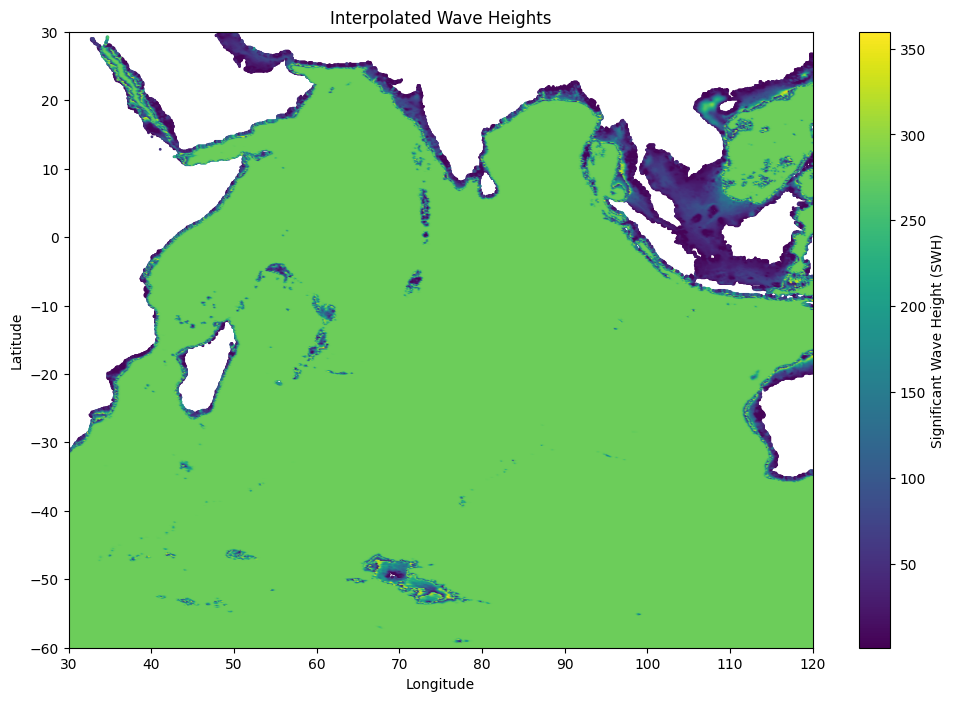

In [36]:
lat_min, lat_max = lat_range
lon_min, lon_max = lon_range
resolution = 0.083

grid_lat = np.linspace(lat_min, lat_max, grid.shape[0])
grid_lon = np.linspace(lon_min, lon_max, grid.shape[1])

# Create meshgrid for plotting
lon_mesh, lat_mesh = np.meshgrid(grid_lon, grid_lat)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(lon_mesh, lat_mesh, 
                      c=grid.ravel(),
                      cmap='viridis', 
                      s=1)  # smaller point size due to more points
plt.colorbar(scatter, label='Significant Wave Height (SWH)')
plt.title('Interpolated Wave Heights')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(30, 120)
plt.ylim(-60, 30)
plt.show()

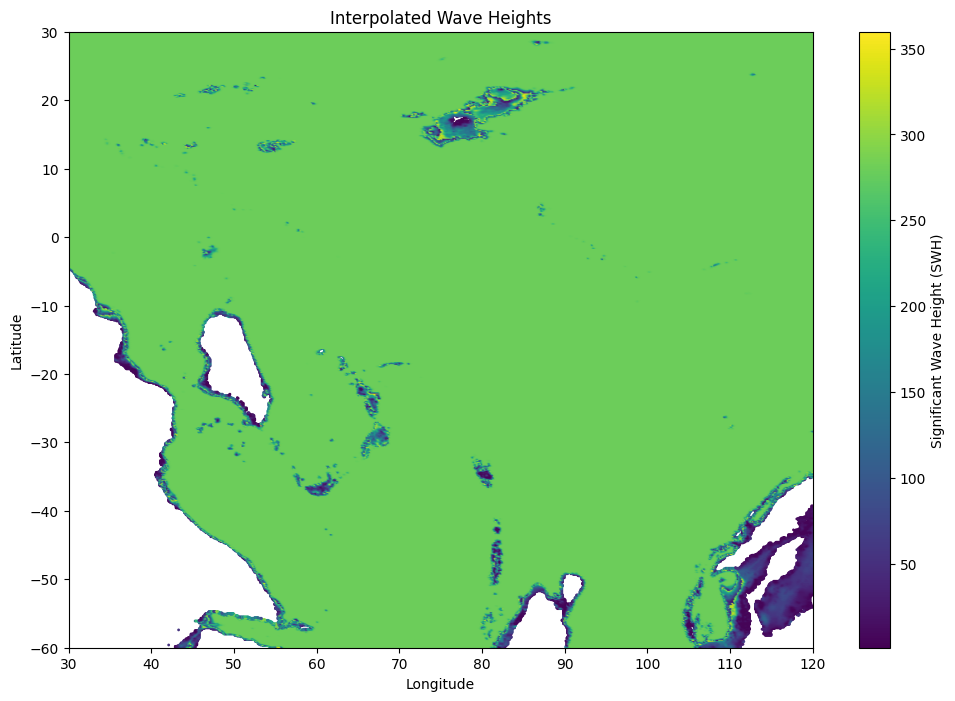

In [38]:
lat_min, lat_max = lat_range
lon_min, lon_max = lon_range
resolution = 0.083

grid_lat = np.linspace(lat_min, lat_max, grid1.shape[0])
grid_lon = np.linspace(lon_min, lon_max, grid1.shape[1])

# Create meshgrid for plotting
lon_mesh, lat_mesh = np.meshgrid(grid_lon, grid_lat)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(lon_mesh, lat_mesh, 
                      c=grid1.ravel(),
                      cmap='viridis', 
                      s=1)  # smaller point size due to more points
plt.colorbar(scatter, label='Significant Wave Height (SWH)')
plt.title('Interpolated Wave Heights')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(30, 120)
plt.ylim(-60, 30)
plt.show()

In [43]:
save_and_load_grid(grid1, "depth_data.npy")

Flipped grid data saved to depth_data.npy
[[         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]
 ...
 [278.99960327 278.99960327 278.99960327 ... 278.99960327 278.99960327
  278.99960327]
 [278.99960327 278.99960327 278.99960327 ... 278.99960327 278.99960327
  278.99960327]
 [278.99960327 278.99960327 278.99960327 ... 278.99960327 278.99960327
  278.99960327]]
(900, 900)


In [46]:
df = load_and_analyze_netcdf("data\Wavewatch_III_25_28_2024_to_03_09_2024.nc")

DataFrame Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620880 entries, 0 to 2620879
Data columns (total 12 columns):
 #   Column   Dtype         
---  ------   -----         
 0   LON      float32       
 1   LAT      float32       
 2   TIME     datetime64[ns]
 3   SWH      float64       
 4   SWHX     float64       
 5   SWHY     float64       
 6   SWELL    float64       
 7   SWELLX   float64       
 8   SWELLY   float64       
 9   TP       float64       
 10  WS       float64       
 11  WINDDIR  float64       
dtypes: datetime64[ns](1), float32(2), float64(9)
memory usage: 220.0 MB
None


In [47]:
df

,LON,LAT,TIME,SWH,SWHX,SWHY,SWELL,SWELLX,SWELLY,TP,WS,WINDDIR
0,30.0,-60.0,2024-08-25 00:00:00,3.780838,2.531515,-2.808232,3.256968,2.339072,-2.266403,12.488085,6.438486,285.309762
1,30.0,-60.0,2024-08-25 03:00:00,4.153642,2.892281,-2.981184,3.484528,2.455056,-2.472778,12.369615,9.587026,284.722093
2,30.0,-60.0,2024-08-25 06:00:00,4.340611,3.312092,-2.805522,3.426492,2.385063,-2.460147,12.308156,12.735564,284.134451
3,30.0,-60.0,2024-08-25 09:00:00,4.340970,3.368739,-2.737812,3.411637,2.345335,-2.477634,12.251069,11.369454,295.032493
4,30.0,-60.0,2024-08-25 12:00:00,4.213192,3.178414,-2.765622,3.390043,2.276020,-2.512395,12.163122,10.003344,305.930533
...,...,...,...,...,...,...,...,...,...,...,...,...
2620875,120.0,30.0,2024-09-03 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2620876,120.0,30.0,2024-09-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2620877,120.0,30.0,2024-09-03 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2620878,120.0,30.0,2024-09-03 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
new_df = extract_data_wave(df, "2024-08-25 06:00:00")

Available Columns: ['LON', 'LAT', 'TIME', 'SWH', 'SWHX', 'SWHY', 'SWELL', 'SWELLX', 'SWELLY', 'TP', 'WS', 'WINDDIR']

First few rows:
     LON   LAT                TIME       SWH      SWHX      SWHY     SWELL  \
0  30.0 -60.0 2024-08-25 00:00:00  3.780838  2.531515 -2.808232  3.256968   
1  30.0 -60.0 2024-08-25 03:00:00  4.153642  2.892281 -2.981184  3.484528   
2  30.0 -60.0 2024-08-25 06:00:00  4.340611  3.312092 -2.805522  3.426492   
3  30.0 -60.0 2024-08-25 09:00:00  4.340970  3.368739 -2.737812  3.411637   
4  30.0 -60.0 2024-08-25 12:00:00  4.213192  3.178414 -2.765622  3.390043   

     SWELLX    SWELLY         TP         WS     WINDDIR  
0  2.339072 -2.266403  12.488085   6.438486  285.309762  
1  2.455056 -2.472778  12.369615   9.587026  284.722093  
2  2.385063 -2.460147  12.308156  12.735564  284.134451  
3  2.345335 -2.477634  12.251069  11.369454  295.032493  
4  2.276020 -2.512395  12.163122  10.003344  305.930533  

Timestamp Column Format:
datetime64[ns]

Unique Times

In [125]:
new_df

,LON,LAT,SWH,WS,WINDDIR
2,30.0,-60.0,4.340611,12.735564,284.134451
82,30.0,-59.5,4.405947,12.733362,290.071529
162,30.0,-59.0,4.470328,11.304623,292.686156
242,30.0,-58.5,4.523293,9.713830,299.071813
322,30.0,-58.0,4.575645,9.985159,314.269690
...,...,...,...,...,...
2620482,120.0,28.0,NaN,NaN,NaN
2620562,120.0,28.5,NaN,NaN,NaN
2620642,120.0,29.0,NaN,NaN,NaN
2620722,120.0,29.5,NaN,NaN,NaN


In [136]:
grid_lon, grid_lat, interpolated_grid = interpolate_wave_heights(new_df)

In [137]:
interpolated_grid

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.36677454, 4.37011239, 4.37345024, ..., 2.84781456, 2.83453138,
        2.8212482 ],
       [4.35369276, 4.35703061, 4.36682457, ..., 2.82774231, 2.8150903 ,
        2.80180712],
       [4.34061098, 4.35040494, 4.3601989 , ..., 2.80767005, 2.79501804,
        2.78236604]])

In [138]:
save_and_load_grid(interpolated_grid,"wave_height3.npy")

Flipped grid data saved to wave_height3.npy
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [4.36677454 4.37011239 4.37345024 ... 2.84781456 2.83453138 2.8212482 ]
 [4.35369276 4.35703061 4.36682457 ... 2.82774231 2.8150903  2.80180712]
 [4.34061098 4.35040494 4.3601989  ... 2.80767005 2.79501804 2.78236604]]
(900, 900)


In [68]:
lat_range = (-30,30)
lon_range = (30,120)

In [94]:
roms_df = load_and_analyze_netcdf("data\ROMS_25_08_2024_to_03_09_2024.nc")

DataFrame Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62208000 entries, 0 to 62207999
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LON       float64       
 1   LAT       float64       
 2   DEPTH1_1  float64       
 3   TAXIS     datetime64[ns]
 4   USURF     float32       
 5   VSURF     float32       
 6   SST       float32       
dtypes: datetime64[ns](1), float32(3), float64(3)
memory usage: 2.5 GB
None


In [95]:
roms_df

,LON,LAT,DEPTH1_1,TAXIS,USURF,VSURF,SST
0,30.0000,-30.0000,0.0,2024-08-25 01:30:00,NaN,NaN,NaN
1,30.0000,-30.0000,0.0,2024-08-25 04:30:00,NaN,NaN,NaN
2,30.0000,-30.0000,0.0,2024-08-25 07:30:00,NaN,NaN,NaN
3,30.0000,-30.0000,0.0,2024-08-25 10:30:00,NaN,NaN,NaN
4,30.0000,-30.0000,0.0,2024-08-25 13:30:00,NaN,NaN,NaN
...,...,...,...,...,...,...,...
62207995,119.8807,29.8927,0.0,2024-09-03 10:30:00,NaN,NaN,NaN
62207996,119.8807,29.8927,0.0,2024-09-03 13:30:00,NaN,NaN,NaN
62207997,119.8807,29.8927,0.0,2024-09-03 16:30:00,NaN,NaN,NaN
62207998,119.8807,29.8927,0.0,2024-09-03 19:30:00,NaN,NaN,NaN


In [112]:
n_df = extract_data_roms(roms_df, "2024-08-25 07:30:00")

Available Columns: ['LON', 'LAT', 'DEPTH1_1', 'TAXIS', 'USURF', 'VSURF', 'SST']

First few rows:
     LON   LAT  DEPTH1_1               TAXIS  USURF  VSURF  SST
0  30.0 -30.0       0.0 2024-08-25 01:30:00    NaN    NaN  NaN
1  30.0 -30.0       0.0 2024-08-25 04:30:00    NaN    NaN  NaN
2  30.0 -30.0       0.0 2024-08-25 07:30:00    NaN    NaN  NaN
3  30.0 -30.0       0.0 2024-08-25 10:30:00    NaN    NaN  NaN
4  30.0 -30.0       0.0 2024-08-25 13:30:00    NaN    NaN  NaN

Timestamp Column Format:
datetime64[ns]

Unique Timestamps:
 <DatetimeArray>
['2024-08-25 01:30:00', '2024-08-25 04:30:00', '2024-08-25 07:30:00',
 '2024-08-25 10:30:00', '2024-08-25 13:30:00', '2024-08-25 16:30:00',
 '2024-08-25 19:30:00', '2024-08-25 22:30:00', '2024-08-26 01:30:00',
 '2024-08-26 04:30:00', '2024-08-26 07:30:00', '2024-08-26 10:30:00',
 '2024-08-26 13:30:00', '2024-08-26 16:30:00', '2024-08-26 19:30:00',
 '2024-08-26 22:30:00', '2024-08-27 01:30:00', '2024-08-27 04:30:00',
 '2024-08-27 07:30:00', '2

In [113]:
n_df

,LON,LAT,USURF,VSURF,SST
2,30.0000,-30.0000,NaN,NaN,NaN
82,30.0000,-29.9167,NaN,NaN,NaN
162,30.0000,-29.8334,NaN,NaN,NaN
242,30.0000,-29.7501,NaN,NaN,NaN
322,30.0000,-29.6668,NaN,NaN,NaN
...,...,...,...,...,...
62207602,119.8807,29.5595,NaN,NaN,NaN
62207682,119.8807,29.6428,NaN,NaN,NaN
62207762,119.8807,29.7261,NaN,NaN,NaN
62207842,119.8807,29.8094,NaN,NaN,NaN


In [101]:
def plot_pooled_mat(pooled_matrix):
    # Calculate new resolution for pooled_matrix
    pooled_lat_res = (lat_range[1] - lat_range[0]) / pooled_matrix.shape[0]
    pooled_lon_res = (lon_range[1] - lon_range[0]) / pooled_matrix.shape[1]

    # Generate grid for pooled latitudes and longitudes
    pooled_grid_lat = np.linspace(lat_range[0], lat_range[1], pooled_matrix.shape[0])
    pooled_grid_lon = np.linspace(lon_range[0], lon_range[1], pooled_matrix.shape[1])

    # Create meshgrid for plotting pooled_matrix
    pooled_lon_mesh, pooled_lat_mesh = np.meshgrid(pooled_grid_lon, pooled_grid_lat)

    # Plot the pooled_matrix as a scatter plot
    plt.figure(figsize=(12, 8))
    pooled_scatter = plt.scatter(pooled_lon_mesh, pooled_lat_mesh, 
                                c=pooled_matrix.ravel(),  # Flatten pooled matrix for scatter plot
                                cmap='viridis', 
                                s=1)  # Smaller point size for dense grid
    plt.colorbar(pooled_scatter, label='Significant Wave Height (SWH)')
    plt.title('Averaged Wave Heights (Pooled)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim(lon_range[0], lon_range[1])
    plt.ylim(lat_range[0], lat_range[1])
    plt.show()


In [121]:
matrix = dataframe_to_matrix(n_df, lat_range, lon_range, val='VSURF')


In [122]:
pooled_matrix = average_pooling(matrix, (600,900))
final_grid = expand_matrix_to_square(pooled_matrix)

final_grid

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

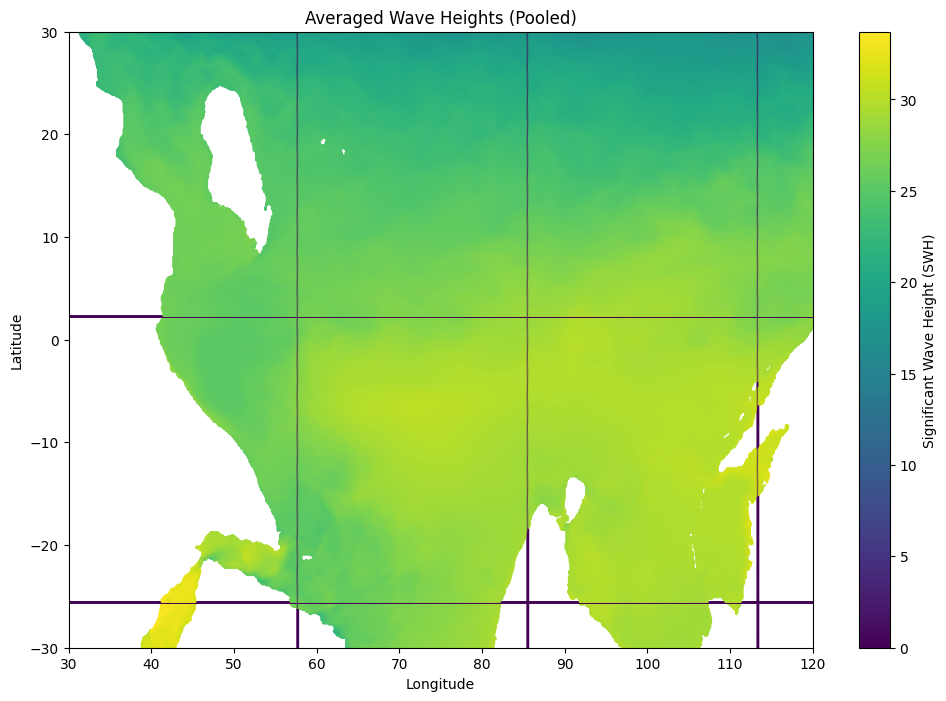

In [116]:
plot_pooled_mat(pooled_matrix)

In [123]:
save_and_load_grid(final_grid, 'vsurf_data3.npy')

Flipped grid data saved to vsurf_data3.npy
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(900, 900)
